### Fisher with many parameters

We write a code that calculates Fisher matrix with more than two free parameters.

Here we leave free  the cosmological parameters $\Omega_{m,0}, \Omega_{b,0}, \sigma_8, n_s, h$. We fix $\Omega_k = 0.0$ and $w = -1$. 

Then we will try to include (and marginalize over) bias parameters at each bin, as well as photo-z parameters.

In [1]:
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate 
from code.plot_utils import plot_pretty
from astropy.io import fits
import skymapper as skm
%matplotlib inline
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
import camb
from camb import model, initialpower

In [3]:
# Now create a class that can create CAMB cosmologies for different values of the free cosmological parameters 

class Cosmology:
    
    def __init__(self,omega_m, omega_b, sigma_8, h, n_s, z):
        self.omega_m = omega_m
        self.omega_b = omega_b
        self.sigma_8 = sigma_8
        self.h = h
        self.n_s = n_s
        self.z = z
        self.k_max = 10.0
        self.c = 2.99792e+5
        #========================================
        
        cosmo = camb.CAMBparams()
        cosmo.set_cosmology(H0=100*self.h, ombh2=self.omega_b*(self.h**2.0), omch2=(self.omega_m - self.omega_b)*(self.h**2.0), mnu=0.06, omk=0, tau=0.06)
        cosmo.InitPower.set_params(As=2.0e-9, ns=self.n_s)
        results = camb.get_results(cosmo)
        cosmo.set_matter_power(redshifts=[0.0], kmax=10.0)
        cambres= camb.get_transfer_functions(cosmo)
        cosmo.NonLinear = model.NonLinear_both
        kh, z, pk = cambres.get_matter_power_spectrum(minkh=1e-3, maxkh=1.0, npoints = 10)
        sigma_8_temp = cambres.get_sigma8()
        As_new  = ((self.sigma_8/sigma_8_temp)**2.0)*(2.0e-9)
        cosmo.InitPower.set_params(As=As_new, ns=self.n_s)
        cambres = camb.get_results(cosmo)
        backres = camb.get_background(cosmo)

        self.chi = backres.comoving_radial_distance(self.z)
           
        self.PK = camb.get_matter_power_interpolator(cosmo, nonlinear=True, 
                hubble_units=False, k_hunit=False, kmax=self.k_max, zmin = 0.0, zmax=self.z[-1]) 
        
        self.H_z = (backres.hubble_parameter(self.z))/self.c #Hubble parameter in 1/Mpc 

In [12]:
# Cell used to  instantize cosmologies 

#Fiducial cosmology - last line from DES paper
#Constraints from DES Y1 + Planck + JLA + BAO

omega_m = 0.301
omega_b = 0.048
sigma_8 = 0.786
h = 0.682
n_s = 0.973
#====================================
#increments for the derivatives 

alpha_om = omega_m/10.0
alpha_ob = omega_b/10.0
alpha_sig = sigma_8/10.0
alpha_h = h/10.0
alpha_ns = n_s/10.0 

#==========================
nz = 1000 #number of steps to use for the radial/redshift integration

zarray = np.linspace(0,4.0,nz)
z = zarray[1:-1]

# Create /instantize cosmologies

cosmo_fid = Cosmology(omega_m, omega_b, sigma_8, h, n_s, z)
cosmo_1 = Cosmology(omega_m + alpha_om, omega_b, sigma_8, h, n_s, z)
cosmo_2 = Cosmology(omega_m - alpha_om, omega_b, sigma_8, h, n_s, z)
cosmo_3 = Cosmology(omega_m, omega_b + alpha_ob, sigma_8, h, n_s, z)
cosmo_4 = Cosmology(omega_m, omega_b - alpha_ob, sigma_8, h, n_s, z)
cosmo_5 = Cosmology(omega_m, omega_b, sigma_8 + alpha_sig, h, n_s, z) 
cosmo_6 = Cosmology(omega_m, omega_b, sigma_8 - alpha_sig, h, n_s, z)
cosmo_7 = Cosmology(omega_m, omega_b, sigma_8, h + alpha_h, n_s, z) 
cosmo_8 = Cosmology(omega_m, omega_b, sigma_8, h - alpha_h, n_s, z)
cosmo_9 = Cosmology(omega_m, omega_b, sigma_8, h, n_s + alpha_ns, z)
cosmo_10 = Cosmology(omega_m, omega_b, sigma_8, h, n_s - alpha_ns, z)


In [66]:
def cosmoselector(om_m, om_b, sig_8, h_con, n_s):
    # function that selects cosmology
    
    #dictionary of different cosmologies
    
    cosmo_dict = {'cosmo_fid': cosmo_fid,
                  'cosmo_1' : cosmo_1,
                  'cosmo_2' : cosmo_2,
                  'cosmo_3' : cosmo_3,
                  'cosmo_4' : cosmo_4,
                  'cosmo_5' : cosmo_5,
                  'cosmo_6' : cosmo_6,
                  'cosmo_7' : cosmo_7,
                  'cosmo_8' : cosmo_8,
                  'cosmo_9' : cosmo_9,
                  'cosmo_10' : cosmo_10}
    
            
    #Fiducial cosmology - last line from DES paper
    #Constraints from DES Y1 + Planck + JLA + BAO
    
    om_m_fid = 0.301 
    om_b_fid = 0.048
    sig_8_fid = 0.786
    h_fid = 0.682
    n_s_fid = 0.973
    
    if (om_m==om_m_fid)&(om_b==om_b_fid)&(sig_8==sig_8_fid)&(h_con==h_fid)&(n_s==n_s_fid):
        cosm_sel = cosmo_dict['cosmo_fid']
    elif (om_m!=om_m_fid):
        if (om_m > om_m_fid):
            cosm_sel = cosmo_dict['cosmo_1']
        else: 
            cosm_sel = cosmo_dict['cosmo_2']
    elif (om_b!=om_b_fid):
        if (om_b > om_b_fid):
            cosm_sel = cosmo_dict['cosmo_3']
        else:
            cosm_sel = cosmo_dict['cosmo_4']
    elif (sig_8!=sig_8_fid):
        if (sig_8 > sig_8_fid):
            cosm_sel = cosmo_dict['cosmo_5']
        else:
            cosm_sel = cosmo_dict['cosmo_6']
    elif (h_con!=h_fid):
        if (h_con > h_fid):
            cosm_sel = cosmo_dict['cosmo_7']
        else:
            cosm_sel = cosmo_dict['cosmo_8']
    else:  
        if (n_s > n_s_fid):
            cosm_sel = cosmo_dict['cosmo_9']
        else:
            cosm_sel = cosmo_dict['cosmo_10']
            
    return cosm_sel

        

In [67]:
# Function that calculates C_l,i

def C_l_i(bias, n_z, om_m_var, om_b_var, sig_8_var, h_var, n_s_var):
    """
    Function that calculates the C_l in a bin
    -----------------
    Inputs:
    bias : bias - constant or function
    n_z : redshift distribution at a redshift bin
    om_m_var: Omega matter - can change
    om_b_var: Omega baryon - can change 
    sig_8_var : Sigma_8 parameter - can change
    h_var : hubble parameter - can change
    n_s_var: primordial tilt - can change
    --------------
    Returns:
    ls and C_l betwenn two bins, i and j. It is the auto spectrum if i=j
    """
    
    c = 2.99792e+5
    
    #======================================
    #====================================================================================
    #====================================================================================
    # Selecting cosmology
    
    cosmo = cosmoselector(om_m_var, om_b_var, sig_8_var, h_var, n_s_var)
    
    #====================================================================================
    #====================================================================================
    #Redshift range for calculations and integration
    
    nz = 1000 #number of steps to use for the radial/redshift integration
    kmax=10.0  #kmax to use

    zarray = np.linspace(0,4.0,nz)
    dzarray = (zarray[2:]-zarray[:-2])/2.0
    zarray = zarray[1:-1]
    
    
    #Calculate square of the window function

    W_sq = (bias*n_z)**2.0
    
    
    #====================================================================================
    #====================================================================================
    #Calculate Hubble parameter and comoving distance
    
    Hubble = cosmo.H_z
    
    # Get comoving distance - in Mpc/h
    chis = cosmo.chi
    
    #========================================================
    # Get the full prefactor of the integral
    prefact = W_sq*Hubble/(chis**2.0)
    #====================================================================================
    
    #===================================================================================
    #===================================================================================
    #Do integral over z
    
    ls_lin = np.linspace(1.0, 3.0, 50, dtype = np.float64)
    ls = 10.0**ls_lin
    
    c_ell=np.zeros(ls.shape)
    w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        c_ell[i] = np.dot(dzarray, w*cosmo.PK.P(zarray, k, grid=False)*prefact)
    
    #===================================================================================
    # Retrurn the array of C_ell
    
    return ls, c_ell

#=======================================================================================
#=======================================================================================
# Here are the derivatives with respect to the cosmological parameters
#=======================================================================================
#=======================================================================================

def matter_der_C_l_i(bias, n_z, om_m, om_b, sig_8, h, n_s):
    """
    Function that calculates the derivative of C_l with respect to matter density in a bin 
    -----------------
    Inputs:
    z_i : Lower limit of the redshift bin
    z_f : Upper limit of the redshift bin
    bias : the linear galaxy bias
    n_z : the normalized redshift distribution
    om_m: Omega matter
    om_b : Omega baryons
    sig_8: Sigma_8 parameter
    h : hubble constant
    n_s : primordial tilt 
    ---------------
    Returns:
    derivative w/r to matter of C_l in a bin i
    """
    alpha = om_m/10.0
    
    C_mat_1 = C_l_i(bias, n_z, om_m+alpha , om_b, sig_8, h, n_s)[1]
    C_mat_2 = C_l_i(bias, n_z, om_m-alpha , om_b, sig_8, h, n_s)[1]
    
    mat_der = (C_mat_1 - C_mat_2)/(2.0*alpha)
    return mat_der
    
#======================================================================================    
#======================================================================================
    
def baryon_der_C_l_i(bias, n_z, om_m, om_b, sig_8, h, n_s):
    """
    Function that calculates the derivative of C_l with respect to baryon density in a bin 
    -----------------
    Inputs:
    z_i : Lower limit of the redshift bin
    z_f : Upper limit of the redshift bin
    bias : the linear galaxy bias
    n_z : the normalized redshift distribution
    om_m: Omega matter
    om_b : Omega baryons
    sig_8: Sigma_8 parameter
    h : hubble constant
    n_s : primordial tilt 
    ----------------
    Returns:
    derivative w/r to matter of C_l in a bin i
    """
    alpha = om_b/10.0
    
    C_bar_1 = C_l_i(bias, n_z, om_m, om_b+alpha , sig_8, h, n_s)[1]
    C_bar_2 = C_l_i(bias, n_z, om_m, om_b-alpha , sig_8, h, n_s)[1]
    
    bar_der = (C_bar_1 - C_bar_2)/(2.0*alpha)
    return bar_der
    
    
#===================================================================================    
#===================================================================================
    
def sigma_der_C_l_i(bias, n_z, om_m, om_b, sig_8, h, n_s):
    """
    Function that calculates the derivative of C_l with respect to sigma_8 between two bins 
    -----------------
    Inputs:
    bias : the linear galaxy bias
    n_z : the normalized redshift distribution
    bias : the linear galaxy bias
    n_z : the normalized redshift distribution
    om_m: Omega matter
    om_b : Omega baryons
    sig_8: Sigma_8 parameter
    h : hubble constant
    n_s : primordial tilt 
    ----------------
    Returns:
    derivative w/r to sigma_8 of C_l in a bin i
    """
    
    alpha = sig_8/10.0
    
    C_sig_1 = C_l_i(bias, n_z, om_m, om_b, sig_8+alpha, h, n_s)[1]
    C_sig_2 = C_l_i(bias, n_z, om_m, om_b, sig_8-alpha, h, n_s)[1]
    
    sig_der = (C_sig_1 - C_sig_2)/(2.0*alpha)
    
    return sig_der

    
#===================================================================================    
#===================================================================================

def hubble_der_C_l_i(bias, n_z, om_m, om_b, sig_8, h, n_s):
    """
    Function that calculates the derivative of C_l with respect to hubble h between two bins 
    -----------------
    Inputs:
    bias : the linear galaxy bias
    n_z : the normalized redshift distribution
    om_m: Omega matter
    om_b : Omega baryons
    sig_8: Sigma_8 parameter
    h : hubble constant
    n_s : primordial tilt 
    ----------------
    Returns:
    derivative of C_l with respect to hubble parameter in a bin i
    """
    
    alpha = h/10.0
    
    C_h_1 = C_l_i(bias, n_z, om_m, om_b, sig_8, h + alpha, n_s)[1]
    C_h_2 = C_l_i(bias, n_z, om_m, om_b, sig_8, h - alpha, n_s)[1]
    
    h_der = (C_h_1 - C_h_2)/(2.0*alpha)
    
    return h_der

#===================================================================================    
#===================================================================================

def tilt_der_C_l_i(bias, n_z, om_m, om_b, sig_8, h, n_s):
    """
    Function that calculates the derivative of C_l with respect to the tilt n_s between two bins 
    ------------------
    Inputs:
    bias : the linear galaxy bias
    n_z : the normalized redshift distribution
    om_m: Omega matter
    om_b : Omega baryons
    sig_8: Sigma_8 parameter
    h : hubble constant
    n_s : primordial tilt
    ----------------
    Returns: 
    derivative of C_l with respect to tilt 
    """
    
    alpha = n_s/10.0
    
    C_tilt_1 = C_l_i(bias, n_z, om_m, om_b, sig_8, h, n_s + alpha)[1]
    C_tilt_2 = C_l_i(bias, n_z, om_m, om_b, sig_8, h, n_s - alpha)[1]
    
    tilt_der = (C_tilt_1 - C_tilt_2)/(2.0*alpha)
    
    return tilt_der

#===================================================================================    
#===================================================================================  

def bias_der_C_l_i(bias, n_z, om_m, om_b, sig_8, h, n_s):
    """
    Function that calculates the derivative of C_l with respect to bias in a bin
    ------------------
    Inputs:
    bias : the linear galaxy bias
    n_z : the normalized redshift distribution
    om_m: Omega matter
    om_b : Omega baryons
    sig_8: Sigma_8 parameter
    h : hubble constant
    n_s : primordial tilt
    ----------------
    Returns: 
    derivative of C_l with respect to bias
    """
    
    alpha = bias/10.0
    
    C_bias_1 = C_l_i(bias + alpha, n_z, om_m, om_b, sig_8, h, n_s)[1]
    C_bias_2 = C_l_i(bias - alpha, n_z, om_m, om_b, sig_8, h, n_s)[1] 
    
    bias_der = (C_bias_1 - C_bias_2)/(2.0*alpha)
    
    return bias_der 

In [68]:
from scipy.interpolate import UnivariateSpline

def Fish_single_bin(z_mean, bias, n_z, f_sky, N_gal):
    """
    Calculates and returns the Fisher matrix for a single bin
    ----------------------------------------
    Inputs:
    z_mean : mean redshift of the bin
    bias : bias - function or constant
    n_z : redshift distribution of the bin
    f_sky : fraction of the sky the survey covers 
    N_gal : number of galaxies in the bin
    
    ---------------------------------------
    Outputs:
    Fisher matrix for a single bin
    """
    
    
    #Fiducial Cosmology goes here 
    
    
    omega_m = 0.301
    omega_b = 0.048
    sigma_8 = 0.786
    h = 0.682
    n_s = 0.973
    
    #Setting up cosmology - need to calculate chis
    
    # Setting up cosmology
    
    cosmo = camb.CAMBparams()
    cosmo.set_cosmology(H0=h*100.0, ombh2=omega_b*(h**2.0), omch2=(omega_m - omega_b)*(h**2.0), mnu=0.06, omk=0, tau=0.06)
    backres = camb.get_background(cosmo)
    #=============================================================
    
    #=============================================================
    
    #Redshift range for calculations and integration
    
    nz = 1000 #number of steps to use for the radial/redshift integration
    kmax=10.0  #kmax to use

    zarray = np.linspace(0,4.0,nz)
    dzarray = (zarray[2:]-zarray[:-2])/2.0
    zarray = zarray[1:-1]
    
    #==============================================================================
    # calculation of l_max
    chi_mean = backres.comoving_radial_distance(z_mean)/h   # comoving distance corresponding to the mean redshift of the bin
    k_cutoff= 0.2*h #Cutoff scale in  Mpc^{-1}
    l_max = int(round(chi_mean*k_cutoff))
    
    #==============================================================================
    #==============================================================================
    #Calculation of the angular number density galaxies / steradian
    
    ster = f_sky*(4.0*np.pi)
    n_bin = N_gal/ster
    
    #===============================================================================
    # Now take the ls, C_ls and the derivatives of the C_ls - then keep only up to lmax
    ell_lin = np.linspace(1.0, 3.0, 50, dtype = np.float64)
    
    C_ell_1 = C_l_i(bias, n_z, omega_m , omega_b, sigma_8, h, n_s)[1] #C_ell's 
    dC_ldOm_1 = matter_der_C_l_i(bias, n_z, omega_m, omega_b, sigma_8, h, n_s)  #matter derivative
    dC_ldOb_1 = baryon_der_C_l_i(bias, n_z, omega_m, omega_b, sigma_8, h, n_s)  #baryon derivative
    dC_ldsig8_1 = sigma_der_C_l_i(bias, n_z, omega_m, omega_b, sigma_8, h, n_s) #sigma_8 derivative
    dC_ldhub_1 = hubble_der_C_l_i(bias, n_z, omega_m, omega_b, sigma_8, h, n_s) #hubble derivative 
    dC_ldtilt_1 = tilt_der_C_l_i(bias, n_z, omega_m, omega_b, sigma_8, h, n_s) #derivative with respect to n_s
    dC_ldbias_1 = bias_der_C_l_i(bias, n_z, omega_m, omega_b, sigma_8, h, n_s) #derivative with respect to bias
    
    #=================================================================================
    #=================================================================================
    #Find the breaking ells now 
    # First initialize 
    l_break_1 = ell_lin[-1]
    l_break_2 = ell_lin[-1]
    l_break_3 = ell_lin[-1]
    l_break_4 = ell_lin[-1]
    l_break_5 = ell_lin[-1]
    for s in range(0,np.size(dC_ldOm_1)):
        if (np.sign(dC_ldOm_1[s])>=0.0):
            l_break_1 = 0.5*(ell_lin[s]+ell_lin[s-1])
        
        if (np.sign(dC_ldOb_1[s])>=0.0):
            l_break_2 = 0.5*(ell_lin[s]+ell_lin[s-1])
        
        if (np.sign(dC_ldhub_1[s])>=0.0):
            l_break_3 = 0.5*(ell_lin[s]+ell_lin[s-1])
        
        if (np.sign(dC_ldtilt_1[s])>=0.0):
            l_break_4 = 0.5*(ell_lin[s]+ell_lin[s-1])
            
        if (np.sign(dC_ldbias_1[s])>=0.0):
            l_break_5 = 0.5*(ell_lin[s]+ell_lin[s-1])
    #=================================================================================        
    #=================================================================================
    ls = np.arange(10,1000, dtype=np.float64) 
    
    C_ell = np.zeros(np.size(ls)) #C_ell's
    dC_ldOm = np.zeros(np.size(ls)) #matter derivative
    dC_ldOb = np.zeros(np.size(ls)) #baryon derivative
    dC_ldsig8 = np.zeros(np.size(ls)) #sigma_8 derivative
    dC_ldhub = np.zeros(np.size(ls)) # hubble derivative
    dC_ldtilt = np.zeros(np.size(ls)) #derivative with respect to n_s
    dC_ldbias = np.zeros(np.size(ls)) #derivative with respect to bias
    #==============================================================================
    
    C_l_matr_interp  = UnivariateSpline(ell_lin, np.log10(C_ell_1+ 1.0e-20))
    C_om_mat_interp = UnivariateSpline(ell_lin, np.log10(abs(dC_ldOm_1+1.0e-20)))
    C_om_bar_interp = UnivariateSpline(ell_lin, np.log10(abs(dC_ldOb_1+1.0e-20)))
    C_sig_interp = UnivariateSpline(ell_lin, np.log10(dC_ldsig8_1+1.0e-20))
    C_hub_interp = UnivariateSpline(ell_lin, np.log10(abs(dC_ldhub_1+1.0e-20)))
    C_tilt_interp = UnivariateSpline(ell_lin, np.log10(abs(dC_ldtilt_1+1.0e-20)))
    C_bias_interp =  UnivariateSpline(ell_lin, np.log10(abs(dC_ldbias_1+1.0e-20)))
    
    #===============================================================================
    for k, l in enumerate(ls):
        ell = np.log10(float(l))
        C_ell[k]  = 10.0**(C_l_matr_interp(ell))
        dC_ldsig8[k] = 10.0**(C_sig_interp(ell))
        if (ell < l_break_1):
            dC_ldOm[k] = -(10.0**C_om_mat_interp(ell))
        else: 
            dC_ldOm[k] = (10.0**C_om_mat_interp(ell))
        
        if (ell < l_break_2):
            dC_ldOb[k] = -(10.0**C_om_bar_interp(ell))
        else: 
            dC_ldOb[k] = (10.0**C_om_bar_interp(ell))
        
        if (ell < l_break_3):
            dC_ldhub[k] = -(10.0**C_hub_interp(ell))
        else: 
            dC_ldhub[k] = (10.0**C_hub_interp(ell))
            
        if (ell < l_break_4):
            dC_ldtilt[k] = -(10.0**C_tilt_interp(ell))
        else: 
            dC_ldtilt[k] = (10.0**C_tilt_interp(ell))
            
        if (ell < l_break_5):
            dC_ldbias[k] = -(10.0**C_bias_interp(ell))
        else: 
            dC_ldbias[k] = (10.0**C_bias_interp(ell))
    #================================================================================
    ls = ls[:l_max-9]
    C_ell = C_ell[:l_max-9]
    dC_ldOm = dC_ldOm[:l_max-9]
    dC_ldOb = dC_ldOb[:l_max-9]
    dC_ldsig8 = dC_ldsig8[:l_max-9]
    dC_ldhub = dC_ldhub [:l_max-9]
    dC_ldtilt = dC_ldtilt[:l_max-9]
    dC_ldbias = dC_ldbias[:l_max-9]
    
    #Create arrays with sigma^2 and its inverse
    sigma_sq = (2.0/(f_sky*(2.0*ls + 1.0)))*((C_ell + 1.0/n_bin )**2.0)
    inv_sigma = 1.0/sigma_sq # inverse of sigma square - that's what we want
    #===============================================================================
    #===============================================================================
    # Calculation of the elements of the Fisher matrix
    Fish = np.zeros([6,6])
    
    # 0 = matter, 1 = baryons, 2 = sigma_8, 3 = h, 4 = n_s, 5 = bias
    
    # Diagonal terms first
    Fish[0,0] = sum(inv_sigma*(dC_ldOm**2.0)) 
    Fish[1,1] = sum(inv_sigma*(dC_ldOb**2.0))
    Fish[2,2] = sum(inv_sigma*(dC_ldsig8**2.0))
    Fish[3,3] = sum(inv_sigma*(dC_ldhub**2.0))
    Fish[4,4] = sum(inv_sigma*(dC_ldtilt**2.0))
    Fish[5,5] = sum(inv_sigma*(dC_ldbias**2.0))
    
    
    #Non-diagonal terms
    Fish[0,1] = Fish[1,0] = sum(inv_sigma*(dC_ldOm*dC_ldOb))
    Fish[0,2] = Fish[2,0] = sum(inv_sigma*(dC_ldOm*dC_ldsig8))
    Fish[0,3] = Fish[3,0] = sum(inv_sigma*(dC_ldOm*dC_ldhub))
    Fish[0,4] = Fish[4,0] = sum(inv_sigma*(dC_ldOm*dC_ldtilt))
    Fish[0,5] = Fish[5,0] = sum(inv_sigma*(dC_ldOm*dC_ldbias))

    Fish[1,2] = Fish[2,1] = sum(inv_sigma*(dC_ldOb*dC_ldsig8))
    Fish[1,3] = Fish[3,1] = sum(inv_sigma*(dC_ldOb*dC_ldhub))
    Fish[1,4] = Fish[4,1] = sum(inv_sigma*(dC_ldOb*dC_ldtilt))
    Fish[1,5] = Fish[5,1] = sum(inv_sigma*(dC_ldOb*dC_ldbias))
    
    Fish[2,3] = Fish[3,2] = sum(inv_sigma*(dC_ldsig8*dC_ldhub))
    Fish[2,4] = Fish[4,2] = sum(inv_sigma*(dC_ldsig8*dC_ldtilt))
    Fish[2,5] = Fish[5,2] = sum(inv_sigma*(dC_ldsig8*dC_ldbias))
    
    Fish[3,4] = Fish[4,3] = sum(inv_sigma*(dC_ldhub*dC_ldtilt))
    Fish[3,5] = Fish[5,3] = sum(inv_sigma*(dC_ldhub*dC_ldbias))
    
    Fish[4,5] = Fish[5,4] = sum(inv_sigma*(dC_ldtilt*dC_ldbias))
    
    return Fish

In [69]:
from scipy.special import gamma
from scipy.special import erf


def Full_Fish(z_init, z_end, N_bins, f_sky, bias, sig_z, N_tot, z_0, a, b):
    """
    Calculates and returns the Fisher matrix for a number of bins
    ---------------------------------
    Inputs:
    z_init: initial redshift of the distribution
    z_end : final reshift of the distribution
    N_bins : Number of bins
    f_sky : fraction of the sky used
    sig_z : photo_z error
    N_tot : total number of galaxies (or total number density)
    z_0, a, b : parameters of the redshift distribution
    ---------------------------------
    Retrurns: The overall Fisher Matrix
    """
    # Create an array in z similar to those used above
    nz = 1000 #number of steps to use for the radial/redshift integration
    kmax=10.0  #kmax to use

    zarray = np.linspace(0.0,4.0,nz)
    dz = (zarray[2:]-zarray[:-2])/2.0
    z = zarray[1:-1]
    
    
    #=================================================================
    # Overall redshift distribution
    
    
    pref = b/(z_0*gamma((a+1.0)/b))
    dNdz = pref*((z/z_0)**a)*np.exp(-(z/z_0)**b)
    
    #=================================================================
    #=================================================================
    #Create N bins and calculate Fisher matrix in each of them
    
    #Width of the bin delta_z
    delta_z = (z_end - z_init)/np.float(N_bins)
    
    Fish_mat  = 0.0 # initalize fisher matrix
    for i in range(0,N_bins):
        z_i = z_init + i*delta_z  # lower redshift limit of the bin
        z_f = z_init + (i+1)*delta_z  # upper redshift limit of the bin
        z_mean = 0.5*(z_i + z_f)
        
        # Photometric window function
        x_min = (z - z_i)/((1.0+z)*sig_z*np.sqrt(2.0))
        x_max = (z - z_f)/((1.0+z)*sig_z*np.sqrt(2.0))
        F_z = 0.5*(erf(x_min) - erf(x_max))
    
        # Normalization
        norm_const = np.dot(dz, dNdz*F_z)
        # Redshift distribution in the bin
        n_z = dNdz*F_z/norm_const
        
        
        
        #Number of galaxies in the bin
        N_gal = N_tot*norm_const
        
        #Add fisher matrix of that bin
        
        Fish_mat += Fish_single_bin(z_mean, bias, n_z, f_sky, N_gal)
        
    return Fish_mat
        
        

In [78]:
z_init = 0.002
z_end = 1.5
N_bins = 5
f_sky = 0.12*0.26
bias = 1.6
sig_z = 0.1
N_tot = 2.0e8
z_0 = 0.6523
a = 1.573
b = 2.284


Fisher =  Full_Fish(z_init, z_end, N_bins, f_sky, bias, sig_z, N_tot, z_0, a, b)

matrix = Fisher

In [79]:
import numpy as np
import math
import sys
import os
import IPython

#=================================================================================

cosmicfish_pylib_path = '/Users/Dimitris/Desktop/2D_clustering/CosmicFish/python'
sys.path.insert(0, os.path.normpath(cosmicfish_pylib_path))

#================================================================================
import cosmicfish_pylib.utilities            as fu
import cosmicfish_pylib.colors               as fc
import cosmicfish_pylib.fisher_matrix        as fm
import cosmicfish_pylib.fisher_derived       as fd
import cosmicfish_pylib.fisher_operations    as fo
import cosmicfish_pylib.fisher_plot_settings as fps
import cosmicfish_pylib.fisher_plot_analysis as fpa
import cosmicfish_pylib.fisher_plot          as fp



In [80]:
param_names = ['$\Omega_{\mbox{m},0}$', '$\Omega_{\mbox{b},0}$','$\sigma_8$', '$h$', '$n_s$', '$b$']

fiducial = [0.301, 0.048, 0.786, 0.682, 0.973, 1.6]

fisher = fm.fisher_matrix(fisher_matrix=matrix, fiducial = fiducial, param_names=param_names )

fisher.name = '5 bins - RedMagiC'

fisher_list = fpa.CosmicFish_FisherAnalysis()
fisher_list.add_fisher_matrix([fisher])
fisher_plotter = fp.CosmicFishPlotter(fishers=fisher_list)

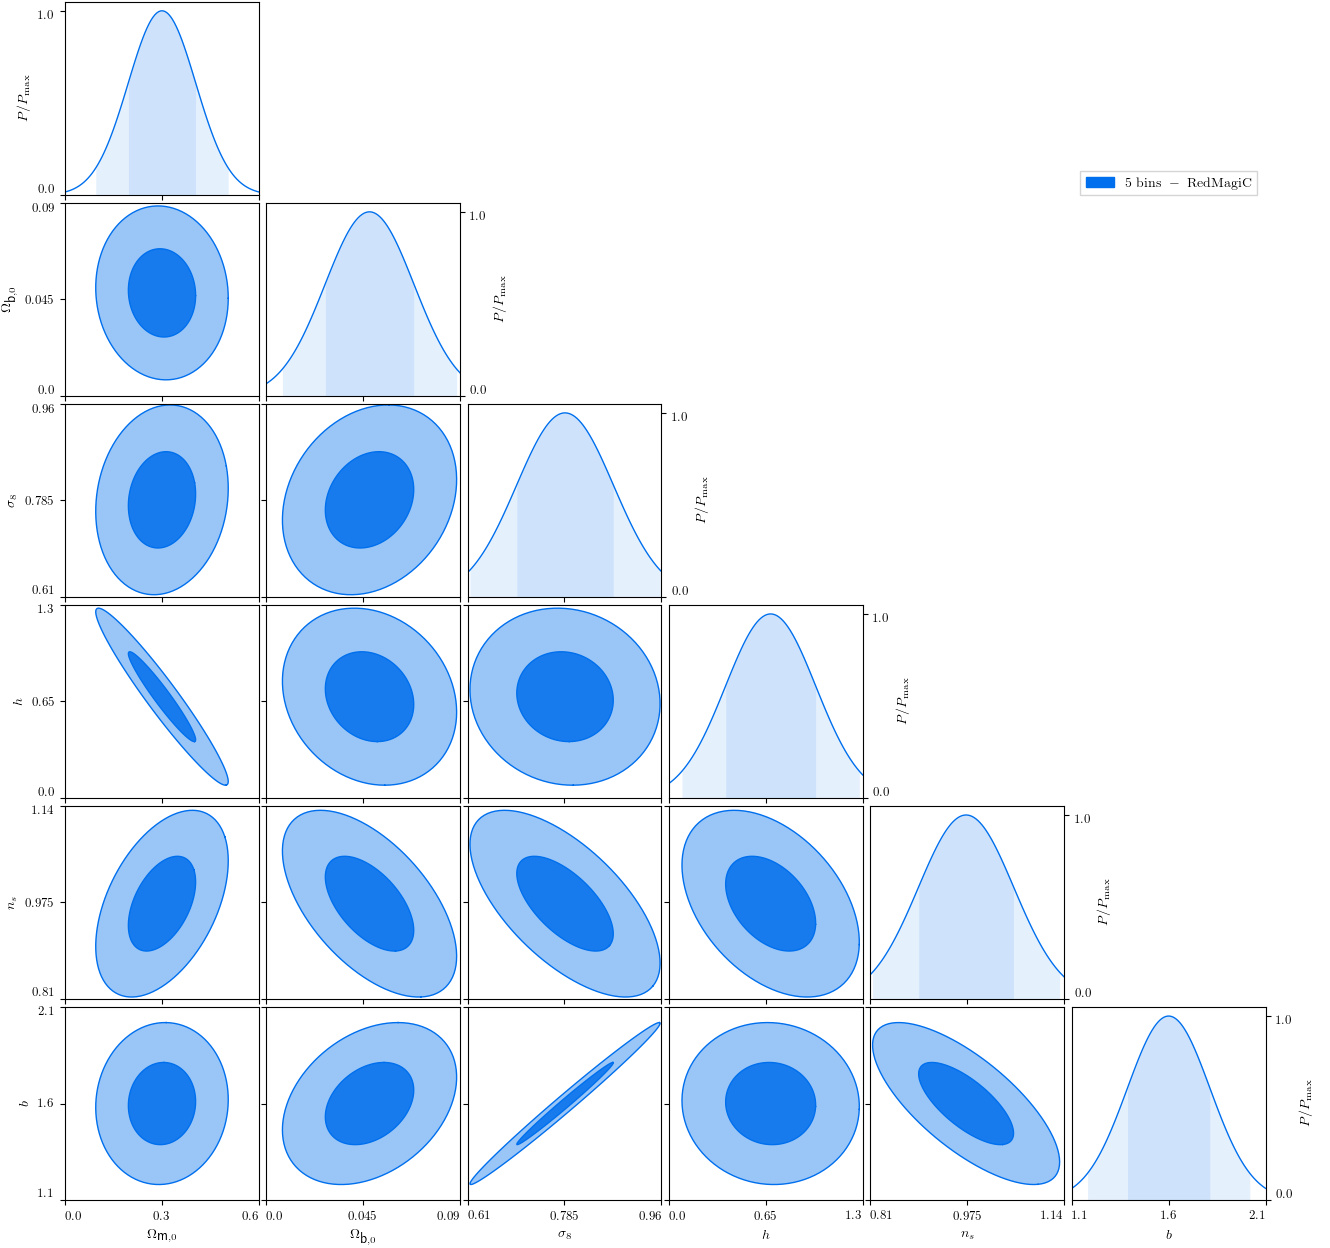

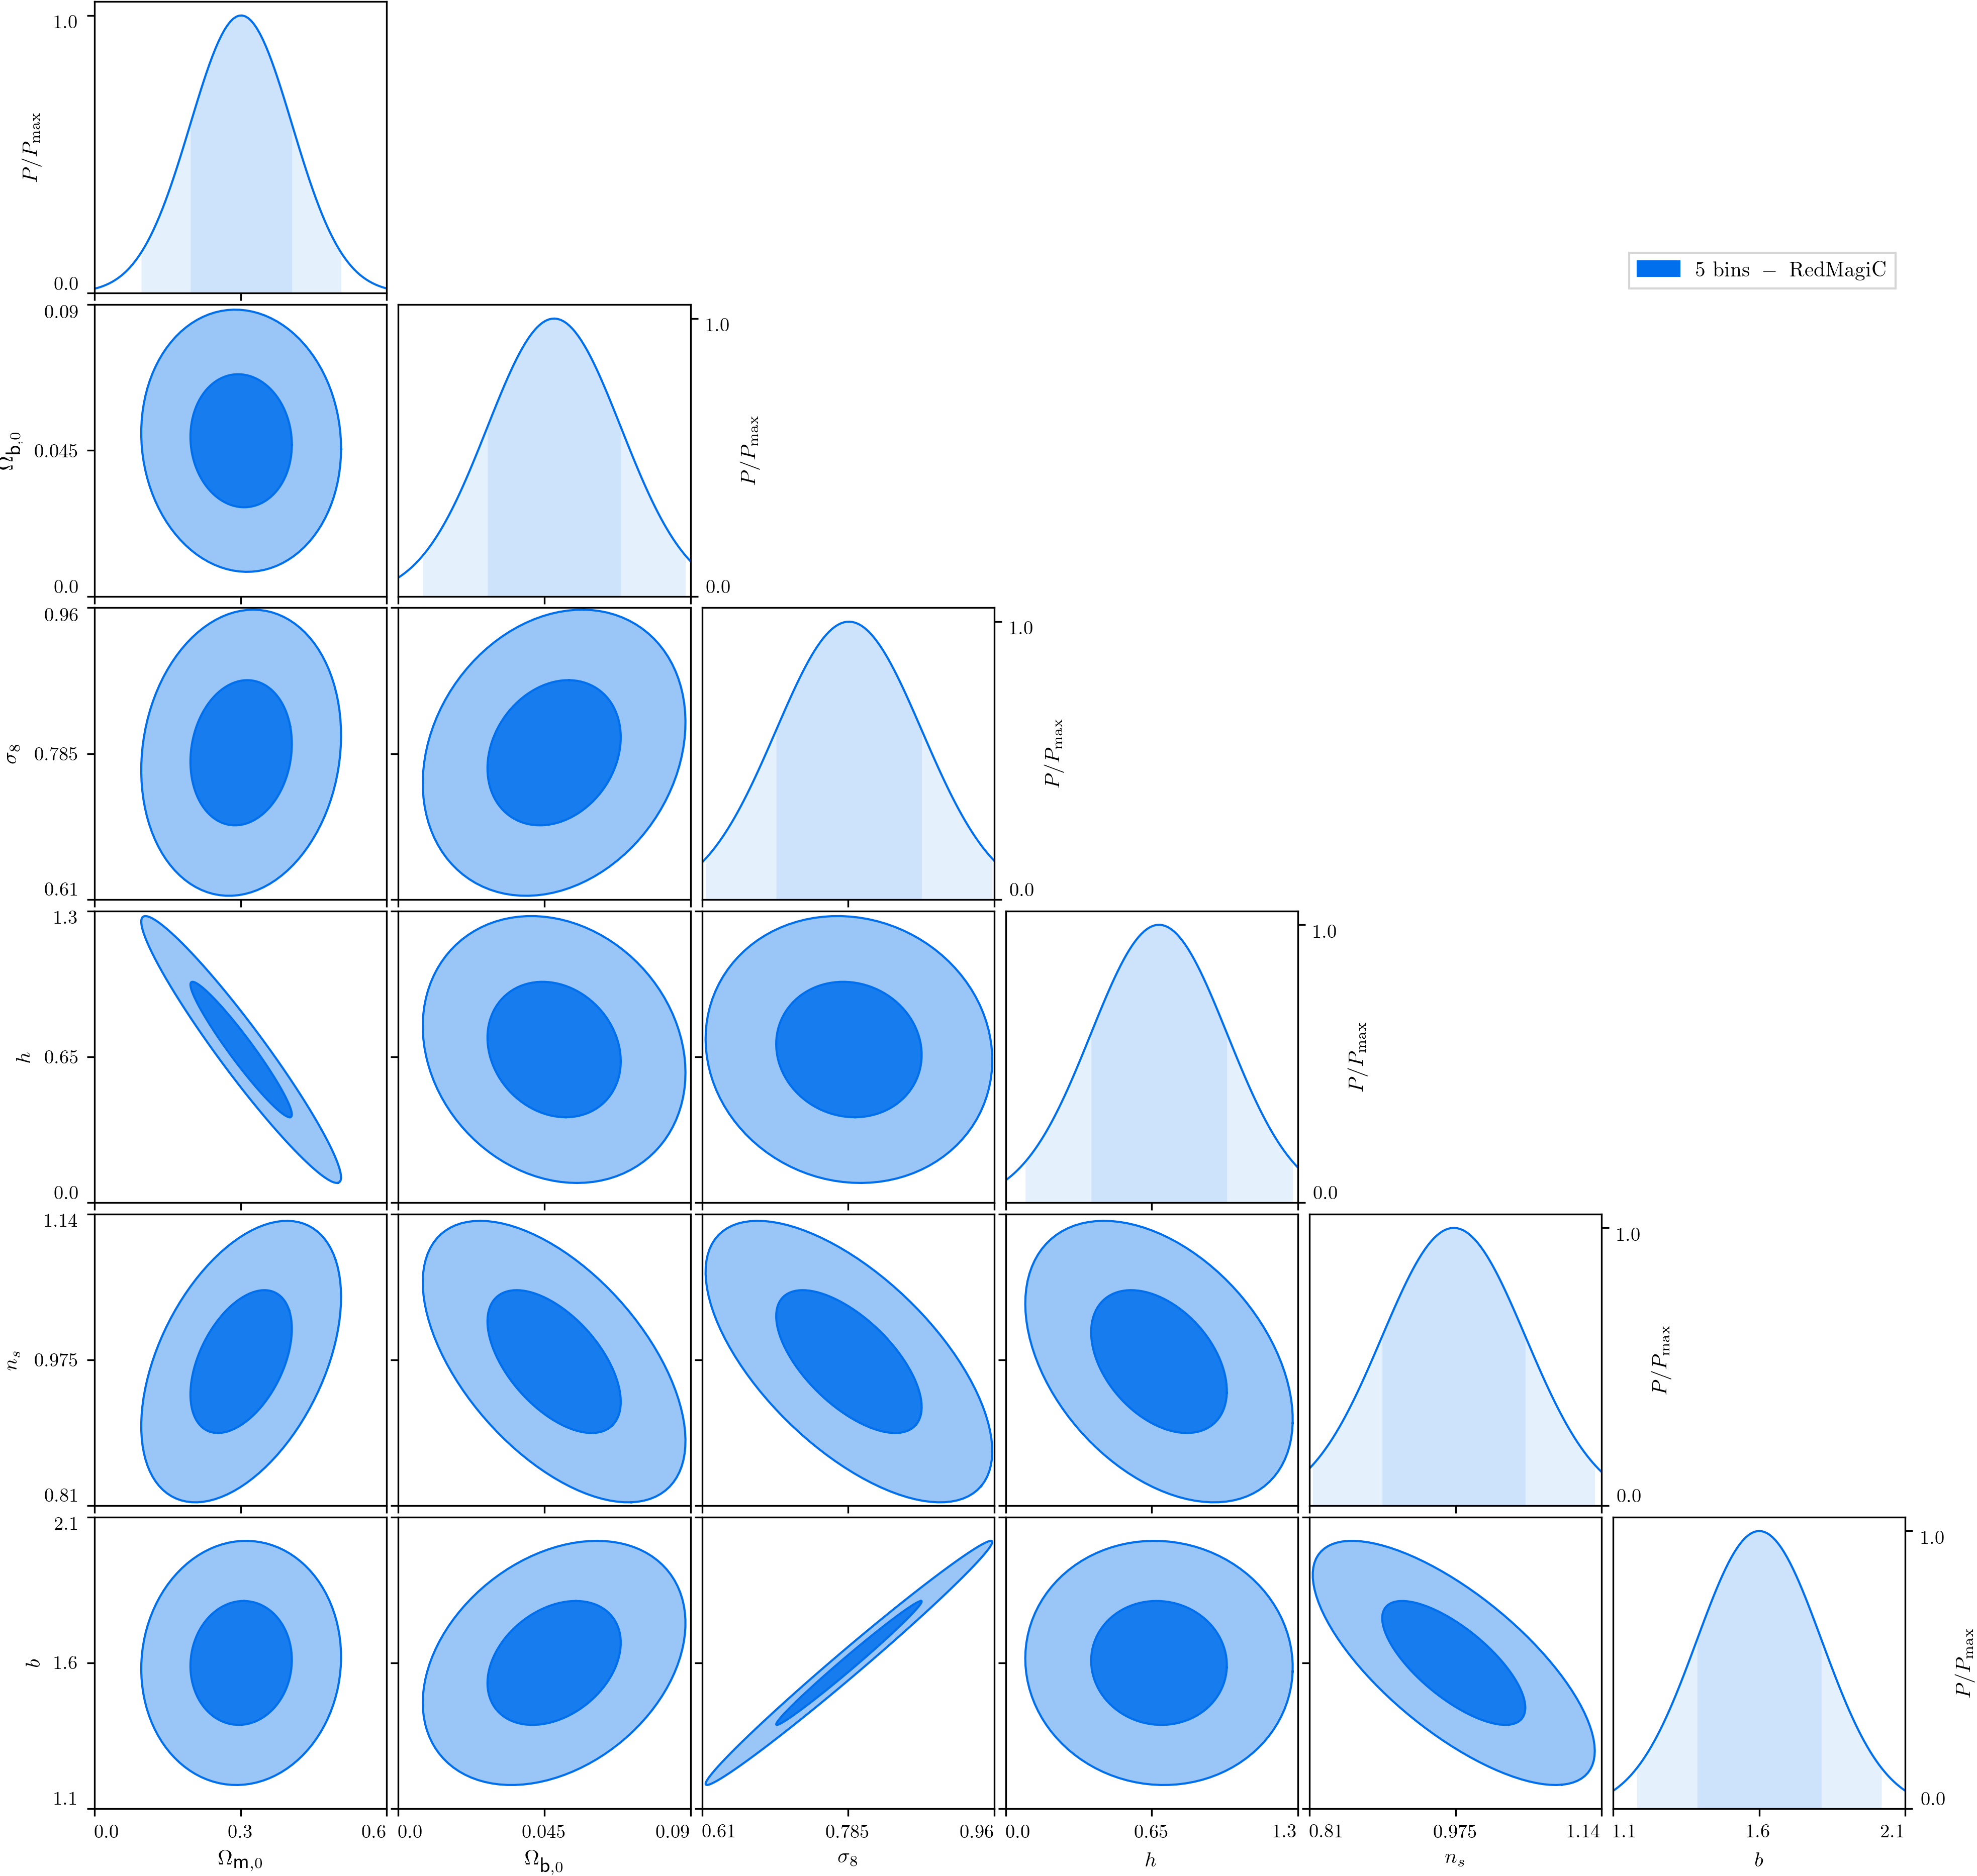

In [81]:
fisher_plotter.new_plot()
fisher_plotter.plot_tri()
fisher_plotter.export('Many.pdf', dpi=100)
fisher_plotter.export('Many.png', dpi=100)
IPython.display.Image(filename='Many.png',unconfined=True)

#### Adding a  prior to the Fisher Matrix

$F_{tot} = F + F_{prior}$

In [82]:
Fish_prior = np.zeros([6,6])

Fish_prior[0,0] = 1.0/(0.2**2.0)
Fish_prior[1,1] = 1.0/(0.001**2.0)
Fish_prior[2,2] = 1.0/(0.2**2.0)
Fish_prior[3,3] = 1.0/(0.2**2.0)
Fish_prior[4,4] = 1.0/(0.2**2.0)
Fish_prior[5,5] = 1.0/(0.2**2.0)

Fish_tot = Fisher + Fish_prior

matrix = Fish_tot

In [83]:
fisher = fm.fisher_matrix(fisher_matrix=matrix, fiducial = fiducial, param_names=param_names )

fisher.name = '5 bins - RedMagiC'

fisher_list = fpa.CosmicFish_FisherAnalysis()
fisher_list.add_fisher_matrix([fisher])
fisher_plotter = fp.CosmicFishPlotter(fishers=fisher_list)

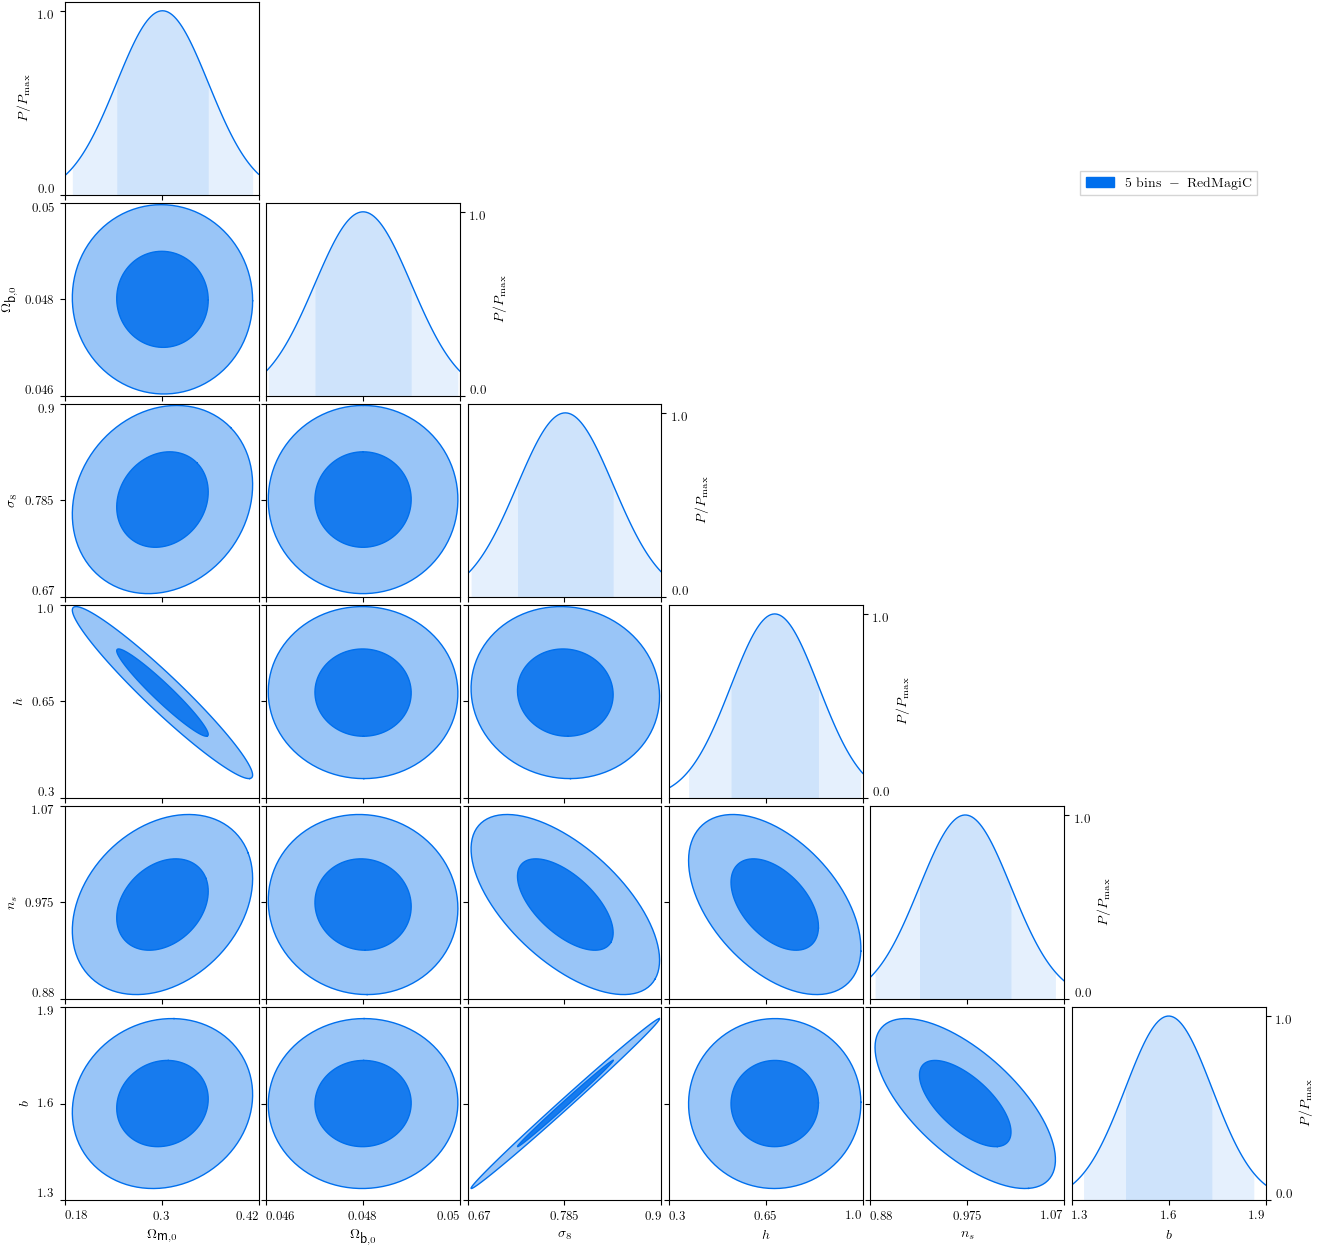

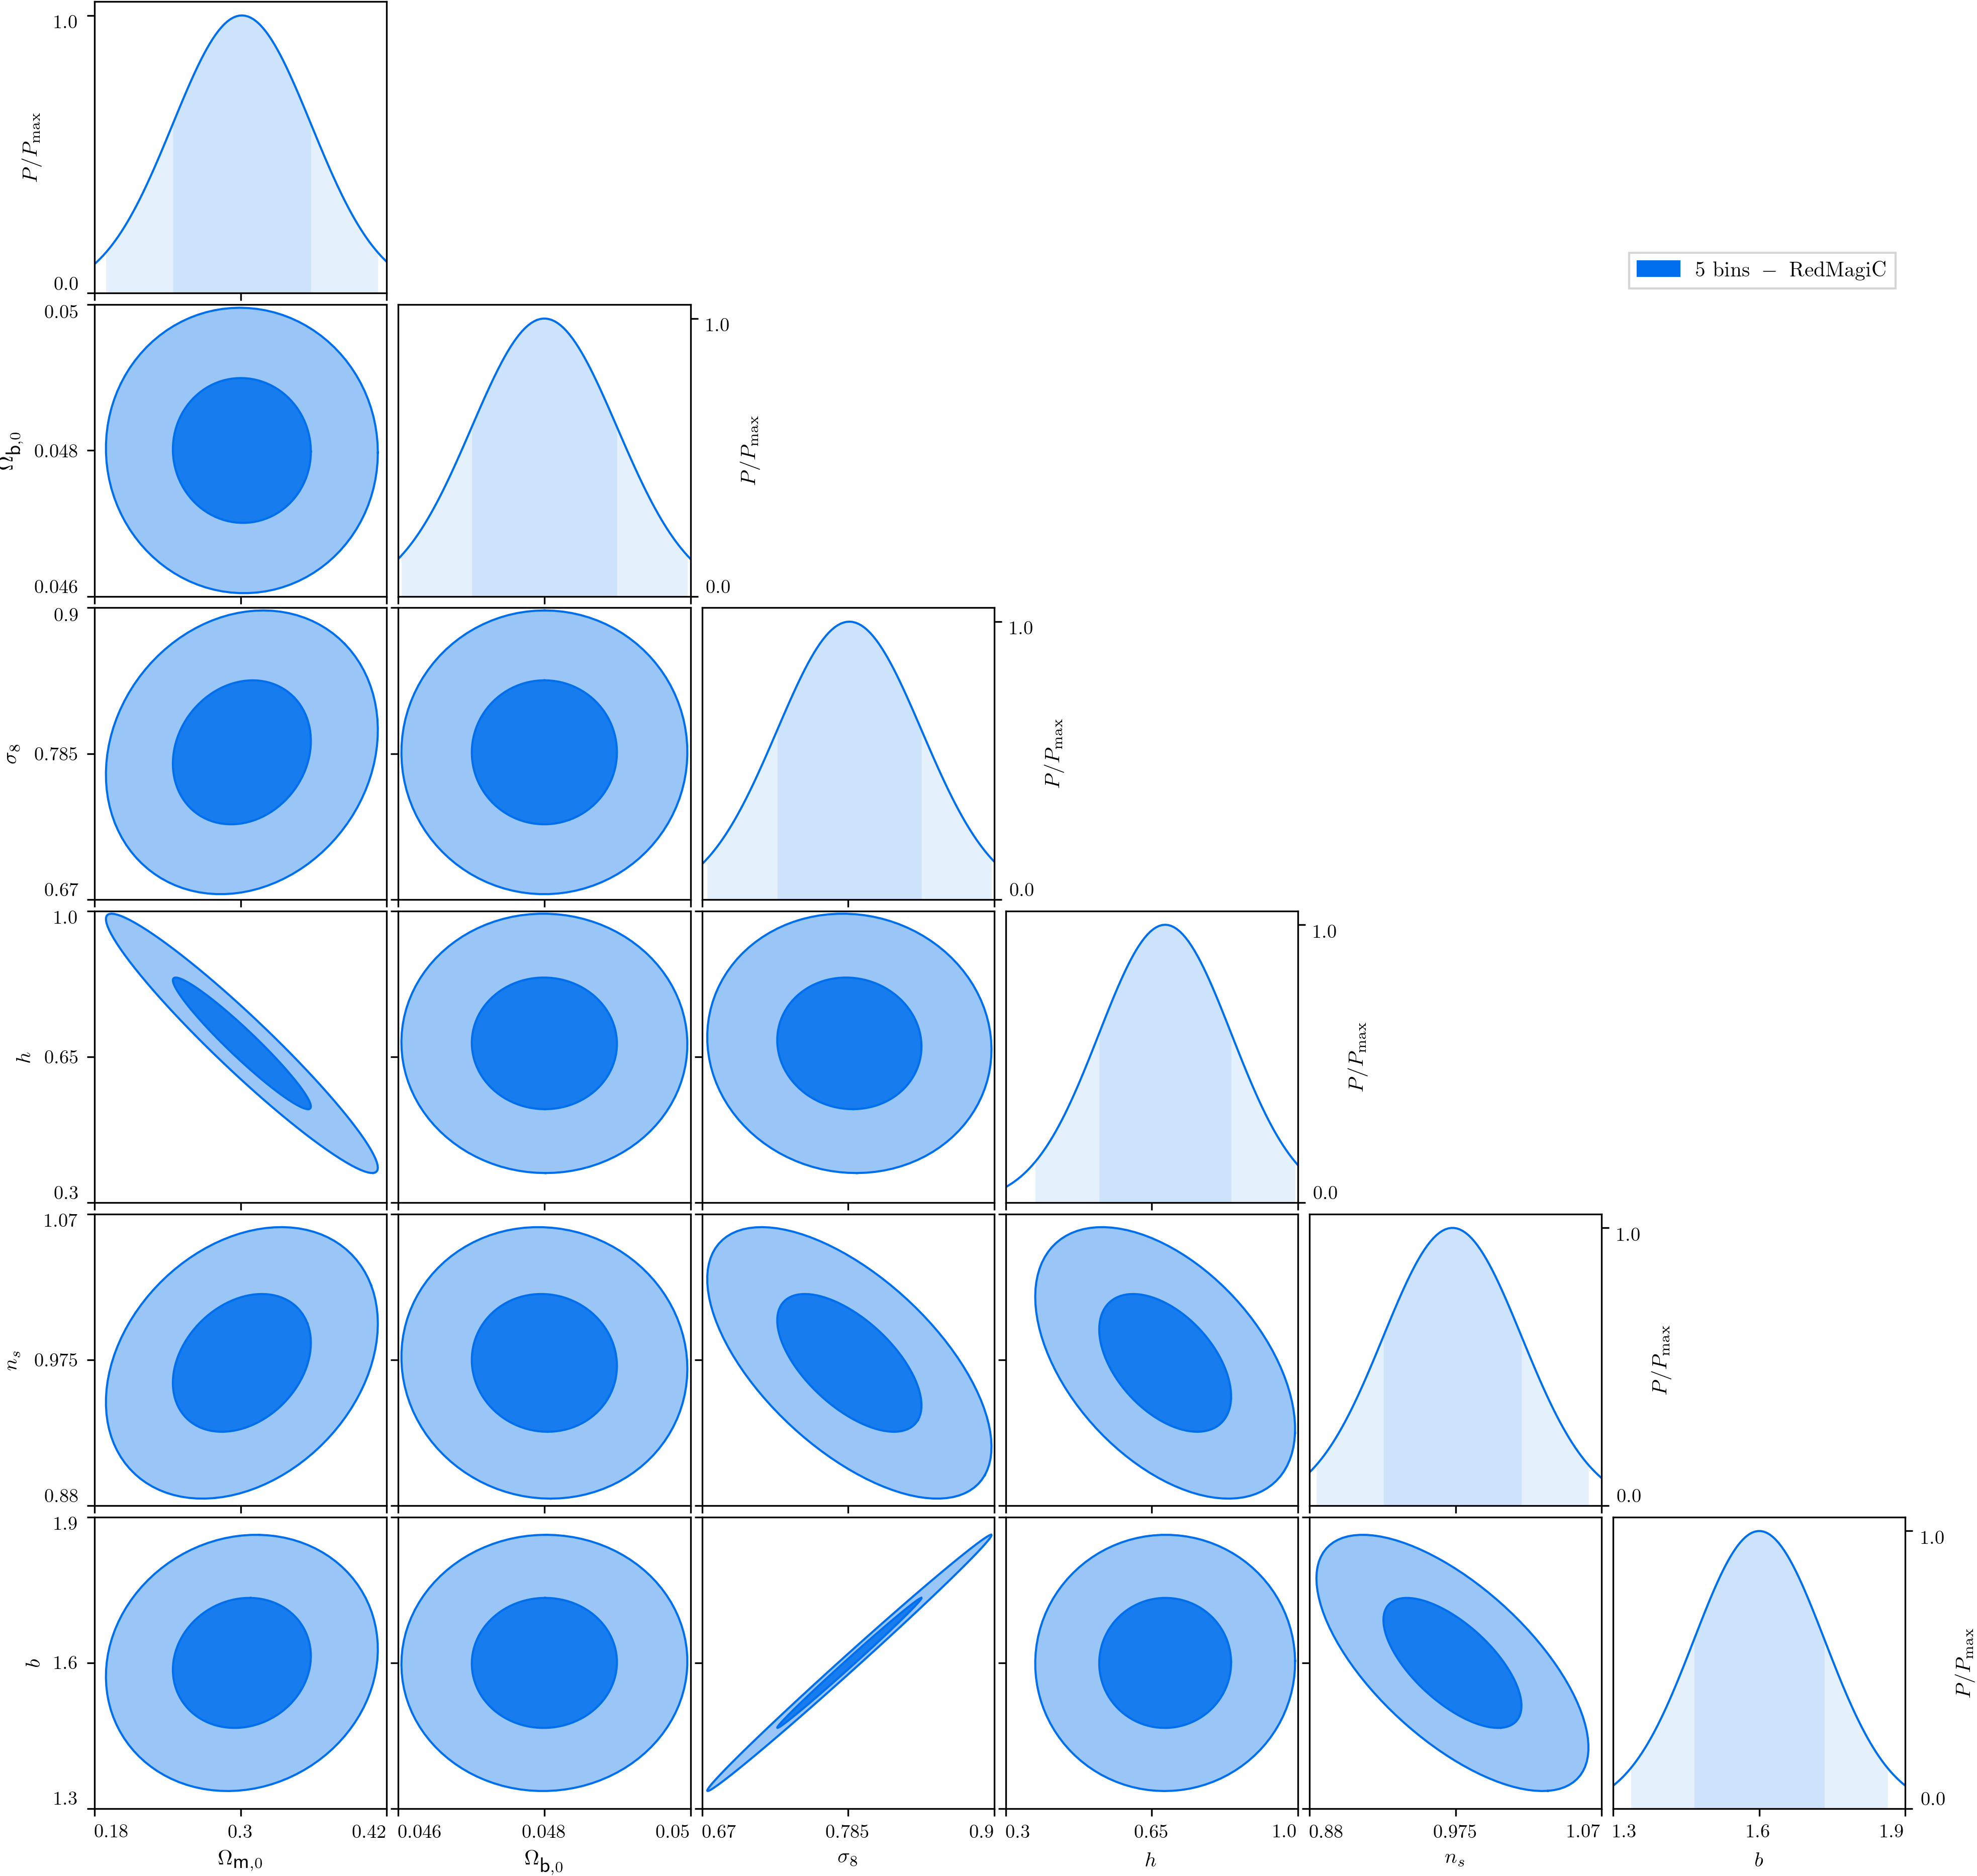

In [84]:
fisher_plotter.new_plot()
fisher_plotter.plot_tri()
fisher_plotter.export('Many.pdf', dpi=100)
fisher_plotter.export('Many.png', dpi=100)
IPython.display.Image(filename='Many.png',unconfined=True)